# Training

In [1]:
import numpy as np
import application
import models
import charts
import matplotlib.pyplot as plt
application.init()

Using TensorFlow backend.


I've got the following components working now:
 * **Speaker database**. Looking at our dataset of audio speaker samples and returning anchor, positive, negative triplets
 * **Audio preprocessing**. Running FFT's on audio samples and breaking them into Mel filter bank energies (log frequency bands)
 * **Batch building**. Build a batch of 32 triplets (anchor, positive, negative), slice each sample into 4 second segments. Preprocess the audio and build a batch of correctly shaped tensors ready to feed into the model.
 * **Model**. A deep neural net model that takes preprocessed audio and produces **speaker embeddings**
 * **Loss function**.  A loss function used to optimize the model using [Triplet Loss](https://en.wikipedia.org/wiki/Triplet_loss)

## Next Steps

### Processing speed
I'm training about one batch per 24 seconds.  This breaks down into two major components:
* **Batch building**. *9 sec*. Reading the audio files and running FFT transforms.  This could be done on another thread. Estimated speedup: about 1/3 faster.
* **Set up GPU**. *15 sec*. I'm currently training on a CPU because I haven't got TensorFlow working on my GPU yet. Estimated speedup: at least 10x.

Based on results I've seen from others doing similar things, I estimate I'll need about 100,000 batches to get good loss.  Just for laughs, let's look at what that'd take with the current approach:

Here is an image from [Wallecplise](https://github.com/Walleclipse/Deep_Speaker-speaker_recognition_system) from their research doing speaker embedding training:
![Walleclipse training losses over time](images/walleclipse-loss.png "Walleclipse training losses")


There's some funny/interesting things in there:
 * How did they have so many losses close to zero? Why did they still have so many losses at 4+ after 85k iterations? As of 329 iterations, I'm not seeing anything close to zero.
 * Why did they see so much variance? I'm not seeing much variance.  Right now I'm at 2.7-3.8 and not much outside of that.  I did see one batch at 1.25 loss at batch 276, but haven't seen it that low since.

In [3]:
batch_build_sec = 9
training_sec = 15
batch_train_sec = 22
need_batches = 100000
seconds_needed = batch_train_sec * need_batches
hours_needed = seconds_needed / 3600
days_needed = hours_needed / 24
days_needed

25.462962962962962

The training situation may not be as bad as I thought.  After 350 epochs I was getting training losses from 2.1-4.2.  It started with losses around 5-6.5.  This was after 2-3 hours of CPU-only training.

## Backlog
Here's a prioritized backlog of things I need to do:
 * **Inference**. Make something that does inference.  Given two samples, decide if they're the same person.  Report on what the alpha is between anchor and positive, and anchor and negative.
     * I'd like to output a confidence level that the two are the same person. What's a good way to do a confidence interval
       given a single scalar?  I get a scalar representing the distance between speakers, and let's say I decide if distance < $\alpha$ that they are the same person.  How do I turn that into a confidence? I could do a histogram plotting the similarity among 100 different speakers, and use that to make a confidence interval.
 * **Include filenames in the batch.** I need to be able to identify specific sound clips that are present in batches so that I can listen to clips that the model is erroneously thinking are the same speaker.
 * **Configure GPU**
     * After configuring GPU, estimate training time needed for 100,000 batches
 * **Chart loss** Show a continuously updated graph of the training process so I can verify that it's making progress.
 * **Optimize audio preprocessing**.  Either do this on another thread, or preprocess the entire dataset
 * **Document model architecture**
 * **Document training processing pipeline**
 * **Add timing** Show time needed to train a batch.  Break that time down into preprocessing and training.  You'll need this for determining when it's time to stop optimizing and just let the thing learn.


 ## Backlog: Done
 * **Checkpoint / reload models** Save the model as it's training periodically, and create a facility to resume training.  Determine how big the model file is, and determine if you want to save N number of models, all models, or just the last x_days worth of models, how often to save, etc.
   * Models are 20Mb.
 * **Log losses**. Append to a log that shows training loss per iteration.  You'll need this for doing charting that persists between incremental training sessions.


# References

 * [FaceNet paper](https://arxiv.org/pdf/1503.03832.pdf) by Florian Schroff, Dmitry Kalenichenko, James Philbin (Google)
 * [Deep Speaker paper](https://arxiv.org/pdf/1705.02304.pdf) Chao Li, Xiaokong Ma, Bing Jiang, Xiangang Li (Baidu)
 * [Walleclipse/Deep_Speaker](https://github.com/Walleclipse/Deep_Speaker-speaker_recognition_system)
 * [philipperemy/deep-speaker](https://github.com/philipperemy/deep-speaker)

In [7]:
import os.path
os.path.exists(r'C:\Users\Richard Lack\Documents\notebooks\voice-embeddings\checkpoints\x.h5')

False

## Check Results
We're still training, but let's write some code that checks the performance and verify we're on the right track.

In [7]:
model = application.load_model()
batch = application.make_batch()

Resuming at batch 13102
Loading model from checkpoints\voice-embeddings.h5
Preloaded model from checkpoints\voice-embeddings.h5


In [3]:
batch.Y

array(['id10795', 'id10609', 'id10366', 'id10013', 'id11045', 'id10800',
       'id10341', 'id10352', 'id11124', 'id10430', 'id10751', 'id10647',
       'id11244', 'id10210', 'id11053', 'id11075', 'id10113', 'id11143',
       'id10445', 'id11118', 'id10905', 'id10938', 'id10265', 'id10317',
       'id10876', 'id10746', 'id11096', 'id10065', 'id10191', 'id10020',
       'id11142', 'id10973', 'id10795', 'id10609', 'id10366', 'id10013',
       'id11045', 'id10800', 'id10341', 'id10352', 'id11124', 'id10430',
       'id10751', 'id10647', 'id11244', 'id10210', 'id11053', 'id11075',
       'id10113', 'id11143', 'id10445', 'id11118', 'id10905', 'id10938',
       'id10265', 'id10317', 'id10876', 'id10746', 'id11096', 'id10065',
       'id10191', 'id10020', 'id11142', 'id10973', 'id10497', 'id10136',
       'id11172', 'id10958', 'id10849', 'id10086', 'id10179', 'id10422',
       'id10239', 'id10737', 'id10144', 'id10776', 'id10378', 'id11141',
       'id10633', 'id11016', 'id10579', 'id10123', 

In [4]:
# samples for speaker 1
s1_id = batch.Y[0]
s1_id

'id10199'

In [5]:
s1_indexes = [i for i in range(len(batch.Y)) if batch.Y[i]==s1_id]
s1_indexes

[0, 32, 76]

In [6]:
x1 = batch.X[0]
x2 = batch.X[32]

In [9]:
emb1 = models.get_embedding(model, x1)
emb2 = models.get_embedding(model, x2)

In [10]:
len(emb1)

512

In [11]:
emb1[0:5], emb2[0:5]

(array([-0.02322356, -0.03748165,  0.03216112, -0.02143482,  0.07364231],
       dtype=float32),
 array([-0.04693886, -0.02959767, -0.01602123, -0.01369595,  0.0623736 ],
       dtype=float32))

## Comparing embeddings

In [14]:
delta = (emb1 - emb2)
delta[0:5]

array([ 0.0237153 , -0.00788398,  0.04818235, -0.00773886,  0.01126871],
      dtype=float32)

In [15]:
delta2 = delta **2
delta2[0:5]

array([5.6241540e-04, 6.2157153e-05, 2.3215392e-03, 5.9890030e-05,
       1.2698371e-04], dtype=float32)

In [16]:
sum(delta2)

0.5299943037522183

In [12]:
def dont_use__difference_emb(emb1, emb2):
    # Don't use this formula.  Use the difference_emb2 below.
    """Returns a scalar indicating the difference between 2 embeddings.
    Smaller numbers indicate closer.
    """
    return np.sum((emb1 - emb2) ** 2)

In [18]:
difference_emb(emb1, emb2)

0.5299943

In [8]:
def difference_sample(model, sample1, sample2):
    """Returns a scalar indicating the difference between 2 sound samples.
    Smaller numbers indicate closer.
    """
    emb1 = models.get_embedding(model, sample1)
    emb2 = models.get_embedding(model, sample2)
    return difference_emb(emb1, emb2)

If this is working properly, we expect these two samples to be similar (low number) because they are from the same speaker:

In [22]:
difference_sample(model, batch.X[1], batch.X[33])

0.3694021

And we expect for these two samples to be a higher number, because they are from different speakers:

In [25]:
difference_sample(model, batch.X[0], batch.X[4])

1.1393651

Let's get several embeddings from several speakers.

In [29]:
embs = [models.get_embedding(model, sample) for sample in batch.X[0:10]]

In [30]:
len(embs)

10

In [31]:
[difference_emb(embs[0], embs[i]) for i in range(len(embs))]

[0.0,
 0.18779477,
 1.3388268,
 1.928726,
 1.1393651,
 0.94274545,
 0.8223575,
 1.2534962,
 2.1065187,
 0.88644737]

In [35]:
emb_speaker_1 = models.get_embedding(model, batch.X[33]) # Another sample from the same speaker as batch.X[1]

In [34]:
difference_emb(embs[1], emb_speaker_1)

0.3694021

So it seems quite confident that these are all difference people, except that it thinks speaker 1 and speaker 0 are the same person.

## Trying a different distance measurement
Here's how we did the distance measurement in my face recognition homework assignment. Let's see if that approach works better:

In [7]:
def difference_emb2(emb1, emb2):
    """Returns a scalar indicating the difference between 2 embeddings.
    Smaller numbers indicate closer.
    """
    dist = np.linalg.norm(emb1 - emb2)
    return dist

In [37]:
[difference_emb2(embs[0], embs[i]) for i in range(len(embs))]

[0.0,
 0.43335295,
 1.1570767,
 1.3887857,
 1.0674105,
 0.9709508,
 0.90683925,
 1.1195965,
 1.4513851,
 0.9415133]

That looks better, although it's still disturbingly close for speaker 0 and 1.

In [6]:
def comparison_matrix(model, batch, qty=3):
    """Compares the embeddings for the samples in a batch.
    All the embeddings in the batch will be placed along the rows and the columns,
    and the difference between each pair of embeddings will be placed in the matrix cells.
    """
    # It wouldn't surprise me if there exists a better, vectorized way to do this.
    embeddings = model.predict(batch.X)
    num_emb = len(embeddings)
    dists = np.zeros((qty, qty))
    qty = min(qty, num_emb)
    # Compare all the embeddings to each other
    for row in range(qty):
        row_emb = embeddings[row]
        for col in range(qty):
            col_emb = embeddings[col]
            dists[row][col] = difference_emb2(row_emb, col_emb)
    return dists

In [39]:
embeddings = model.predict(batch.X)

In [40]:
embs[0][:5]

array([-0.02322356, -0.03748165,  0.03216112, -0.02143482,  0.07364231],
      dtype=float32)

In [41]:
embeddings[0][:5]

array([-0.02322355, -0.03748164,  0.03216112, -0.02143481,  0.07364228],
      dtype=float32)

In [57]:
comparison = test_batch(model, batch, qty=5)
comparison

array([[0.        , 0.43335292, 1.15707672, 1.38878548, 1.06741023],
       [0.43335292, 0.        , 1.2794354 , 1.40750265, 0.87894404],
       [1.15707672, 1.2794354 , 0.        , 1.1368717 , 1.22973502],
       [1.38878548, 1.40750265, 1.1368717 , 0.        , 1.4543308 ],
       [1.06741023, 0.87894404, 1.22973502, 1.4543308 , 0.        ]])

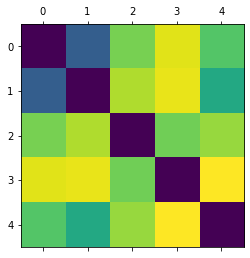

In [58]:
plt.matshow(comparison)

In [16]:
comparison=comparison_matrix(model, batch, qty=32)

In [10]:
def plot_comparison(model, batch, qty=96):
    comparison = comparison_matrix(model, batch, qty)
    plt.figure(figsize=(12,8))
    plt.imshow(comparison)
    plt.colorbar()

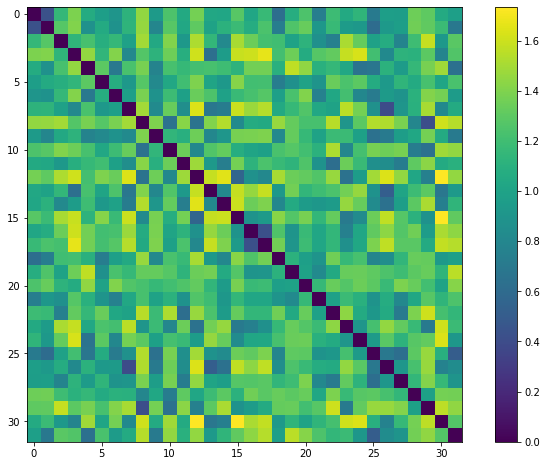

In [72]:
plot_comparison(model, batch, qty=32)

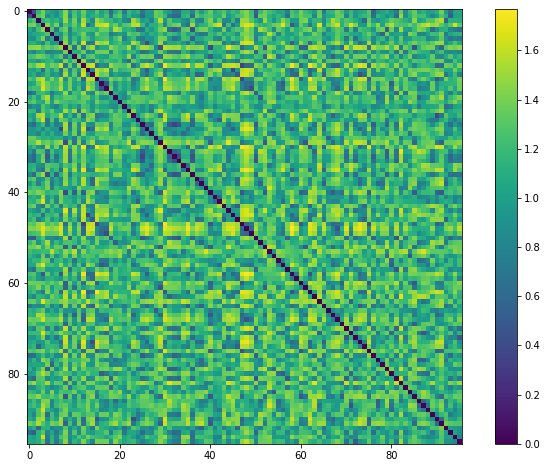

In [71]:
plot_comparison(model, batch)

There are a few darker colored pixels here and there that might indicate difficulty in telling speakers apart.  The model is still training, though, so I'm not too worried.  These shots were taken after training epoch 8831, which may be pretty early times still for training.

Who are these two speakers it's having trouble differentiating?  Do they sound similar to *me* as a creature who is expert at neural sound processing?

In [75]:
batch.Y[0:2]

array(['id10199', 'id10380'], dtype='<U7')

I went and listened to some samples of these two speakers, and don't feel too terrible about it identifying them as the same person.

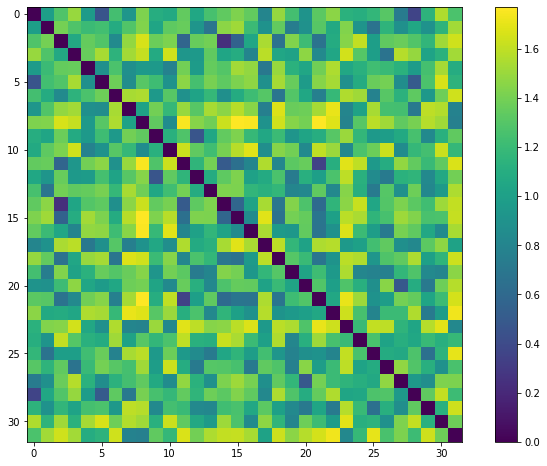

In [11]:
plot_comparison(model, batch, qty=32)

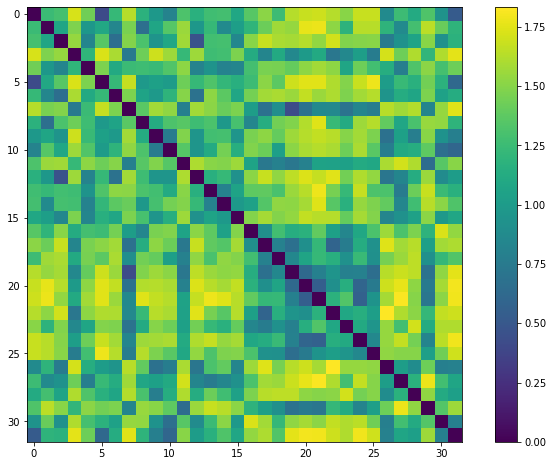

In [3]:
charts.plot_comparison(model, batch, qty=32)

Let's look at the range of values that we get when comparing speakers.

Comparisons to make:
 * Histogram of comparisons of same speaker. I hope for this to be a range of small values.
 * Histogram of comparisons of different speakers I hope for this to be a range of larger values.

In [8]:
import analysis
comparison = analysis.comparison_matrix(model, batch, qty=96)

In [9]:
from analysis import difference_emb
import charts
def performance_comparisons(comparison):
    same_speakers = []
    different_speakers = []
    for row in range(comparison.shape[0]):
        for col in range(comparison.shape[1]):
            if col == row:
                continue
            val = comparison[row][col]
            is_same = (col == row + 32) or (row == col + 32)
            if is_same:
                same_speakers.append(val)
            else:
                different_speakers.append(val)
    return same_speakers, different_speakers

def performance_histogram(comparison):
    same_speakers, different_speakers = performance_comparisons(comparison)
    charts.histogram(same_speakers, title='Same Speakers')
    charts.histogram(different_speakers, title='Different Speakers')

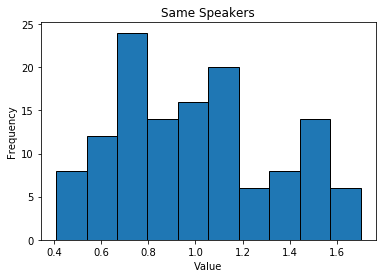

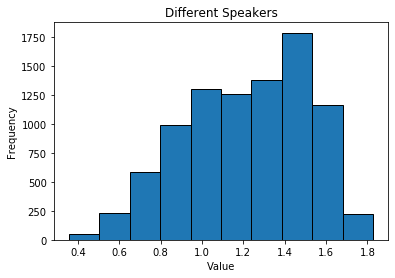

In [10]:
performance_histogram(comparison)

Given the distance, what is the probability that two samples are the same speaker?

$$P(A | B) =  $$

In [16]:
bins = np.array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8])
same, different = performance_comparisons(comparison)

In [22]:
counts, bins = np.histogram(same)

In [23]:
sum(counts)

128

In [24]:
counts

array([ 8, 12, 24, 14, 16, 20,  6,  8, 14,  6], dtype=int64)

In [25]:
bins

array([0.41000977, 0.53896916, 0.66792855, 0.79688794, 0.92584733,
       1.05480672, 1.18376611, 1.31272551, 1.4416849 , 1.57064429,
       1.69960368])

In [27]:
bins[0:5]

array([0.41000977, 0.53896916, 0.66792855, 0.79688794, 0.92584733])

In [28]:
sum(counts[0:5])

74

In [29]:
74/128

0.578125

In [30]:
counts, bins = np.histogram(different)

In [31]:
bins

array([0.35627827, 0.50344475, 0.65061123, 0.79777772, 0.9449442 ,
       1.09211068, 1.23927716, 1.38644364, 1.53361012, 1.68077661,
       1.82794309])

In [33]:
sum(counts)

8992

In [34]:
sum(counts[0:5])

3164

In [35]:
3164/8992

0.35186832740213525

Let's look at comparisons using dot products, the same way our loss function works.

In [42]:
def compare2(model, batch):
    embeddings = model.predict(batch.X)
    emb_same = [] # Pairs of embeddings where both samples are from the same speaker.
    emb_diff = [] # Pairs of embeddings where both samples are from different speakers.
    for i in range(32):
        anchor = embeddings[i]
        emb_same.append((anchor, embeddings[i+32]))
        emb_diff.append((anchor, embeddings[i+64]))
    return emb_same, emb_diff

In [43]:
same,diff = compare2(model,batch)

In [48]:
same[0][0][0:5], same[0][1][0:5]

(array([ 0.01316172, -0.01770374,  0.04380926,  0.00432461,  0.01710355],
       dtype=float32),
 array([ 0.04849419, -0.0222795 , -0.00039857,  0.03375416, -0.05869795],
       dtype=float32))

In [49]:
pair = same[0]

In [50]:
np.dot(pair[0], pair[1])

0.4769954

In [51]:
same_dots = [np.dot(a,b) for (a,b) in same]

In [52]:
same_dots[0:4]

[0.4769954, 0.5841879, 0.5215398, 0.73788154]

In [53]:
np.mean(same_dots)

0.65096223

In [54]:
diff_dots = [np.dot(a,b) for (a,b) in diff]

In [55]:
np.mean(diff_dots)

0.17848873

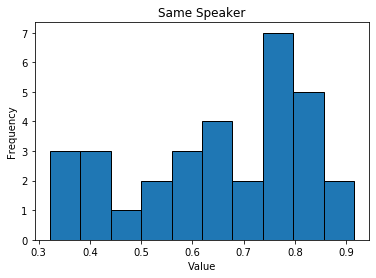

In [57]:
charts.histogram(same_dots, title='Same Speaker')

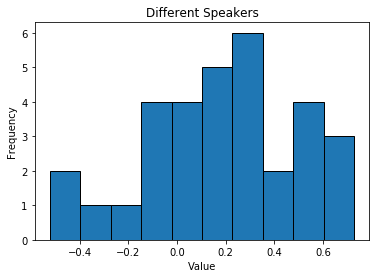

In [58]:
charts.histogram(diff_dots, title='Different Speakers')

The resulting similarity ranges from −1 meaning exactly opposite, to 1 meaning exactly the same, with 0 indicating orthogonality or decorrelation.

In [63]:
len([d for d in same_dots if d>0.6])

21

In [64]:
len(same_dots)

32

In [65]:
21/32

0.65625

In [66]:
len([d for d in diff_dots if d>0.6])

3

In [67]:
len(diff_dots)

32

In [68]:
3/32

0.09375

In [70]:
def predictive_power(same, diff, threshhold):
    pos_detect = len([d for d in same if d>threshhold]) / len(same)
    neg_detect = len([d for d in diff if d>threshhold]) / len(diff)
    return pos_detect, neg_detect

In [72]:
predictive_power(same_dots, diff_dots, 0.5)

(0.78125, 0.21875)

In [76]:
predictive_power(same_dots, diff_dots, 0.4)

(0.90625, 0.25)

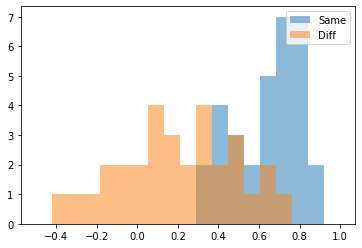

In [85]:
bins = np.linspace(-0.5, 1.0, 20)
plt.hist(same_dots, bins, alpha=0.5, label='Same')
plt.hist(diff_dots, bins, alpha=0.5, label='Diff')
plt.legend(loc='upper right')
plt.show()